In [1]:
# Import your favourite library
import pennylane as qml

# Import Numpy from PennyLane
from pennylane import numpy as np

# Import the library that you need in order to use your IBM account
# import qiskit_ibm_provider

# IBM_token = #'Your Token Goes Here'

# try:
#     qiskit_ibm_provider.IBMProvider()
# except:
#     qiskit_ibm_provider.IBMProvider.save_account(token=IBM_token, overwrite=True)

In [15]:
arr = [0.1049940817641552, 0.08319754261087875, 0.10203799347859205, 0.11068220314990984, 0.08589520984830018, 0.11122625687662319, 0.09478272786722025, 0.10933613535293185, 0.10708720509698799, 0.09701096366524997, 0.10051090320067757, 0.10455407653657711, 0.08436091799110768, 0.08643207672017017, 0.10512807314990913, 0.0929481181326916, 0.09885148146089812, 0.0918360137148157, 0.10222579696873929, 0.08797746553485025, 0.10386095401007328, 0.09594440819986849, 0.10394696336677062, 0.11114028041523366, 0.09714568668348111, 0.08769584140637166, 0.10286374324596637, 0.08766903246690866, 0.08996885470811228, 0.09904975375681174, 0.09287367027228233, 0.1033884422642875, 0.09846109141739562, 0.10698161122394195, 0.09422614093706533, 0.11303879195127114, 0.10511987365229797, 0.09635474994640442, 0.09444596287955598, 0.09046925948599654, 0.10069054619118106, 0.09745931447395356, 0.09845732555309966, 0.08674211270107135, 0.07859709445030494, 0.10015126463025198, 0.09905447750790675, 0.09047238419596093, 0.09508532354762211, 0.10276401050200662, 0.10323651675397372, 0.0922712233799976, 0.10211693302846142, 0.0930854097832211, 0.08400116572958316, 0.0947750550012369, 0.08450897984913647, 0.09656622956556066, 0.07794884456901002, 0.08165240142768221, 0.09781113789746798, 0.08951187981456593, 0.08337083734626444, 0.10223311210201924, 0.1026910604444809, 0.09720353466649223, 0.10062896055370724, 0.10602552900395112, 0.092088008027217, 0.10266277515359101, 0.10047565611216946, 0.09161127569390837, 0.0981842802784279, 0.10012724883071894, 0.10409295585818201, 0.08820929840746111, 0.09039234876485036, 0.10124466195493598, 0.09747612907993308, 0.1113921622103245, 0.09159746616199782, 0.10495942060880187, 0.09491196758133591, 0.09219575186480317, 0.08971990094997911, 0.09686830269372099, 0.08557896786566732, 0.10355248599626671, 0.10821595272783485, 0.08654439771462547, 0.08984725150998096, 0.099751293492149, 0.08838582214799445, 0.08298514868161666, 0.08724967786882848, 0.09479331124178808, 0.10302855646852266, 0.09734486916541113, 0.09867623277902071, 0.09489066644182526, 0.09049735730678671, 0.10213202882454026, 0.10753876344868707, 0.1104107644960235, 0.1072884063920665, 0.10022321452150906, 0.10170703390157204, 0.09009924109348671, 0.09097163206957204, 0.09923947530750371, 0.09231864762539299, 0.09180424412589983, 0.07833039711592515, 0.08818295674998883, 0.08047951830133515, 0.0906906399723742, 0.08628431709235734, 0.09524306630269014, 0.08807825303673611, 0.0904514319861025, 0.08575885015777807, 0.1049591238029966, 0.08984004779627514, 0.08973655771413919, 0.09046954665681667, 0.10081039708490214, 0.08471606249078534, 0.08503359146255995, 0.09618773571102379, 0.09123797625426017, 0.0957343665111472, 0.08487092594672718, 0.08927527704798127, 0.10021521211846107, 0.08250710549551654, 0.1024028969125641, 0.09752741699213663, 0.09676544038370505, 0.08881561869547511, 0.09059971529670036, 0.10280301790534574, 0.08419180853898944, 0.1031347693820383, 0.09280366993422384, 0.09605726018961414, 0.10245814934950664, 0.09223679546169794, 0.08885539089283628, 0.09010874498318322, 0.09765002692236419, 0.09478153367670777, 0.09933724772455932, 0.09176974062626742, 0.10149191252440548, 0.09384047608303409, 0.09359284971115683, 0.09639784313384414, 0.09369512225986792, 0.08914827267024467, 0.08622775268877875, 0.09884841323468518, 0.0939372186515538, 0.09099255233855635, 0.09977996378992876, 0.08956784211436486, 0.08771321884669098, 0.10273298777703671, 0.09946549884605549, 0.10297999296062743, 0.09434888761039473, 0.08333564677691546, 0.08554350736486604, 0.07693780243799858, 0.09496072210161405, 0.09772555592260967, 0.10221449228968638, 0.10134612172853946, 0.0926497216410701, 0.09691526056167166, 0.08515824164782504, 0.09952329613755745, 0.1035702188582398, 0.07817931249205862, 0.08297726224476254, 0.09132664659176731, 0.10801427997867774, 0.10264239015712828, 0.09007918669081394, 0.09630568673145834, 0.093364189518502, 0.10106333575102477, 0.11019300332135262, 0.08892733220015503, 0.10473529319302494, 0.10167203798885355, 0.10798602712738747, 0.0980039766895126, 0.08765601435179488, 0.09607218761794944, 0.09374578189608979, 0.0817856343695586, 0.10052545535351093, 0.09252871103645449, 0.10732997898816304, 0.08994868283092444, 0.09490564054951733, 0.08960529622667968, 0.09175880426353483, 0.09694776561096363, 0.09816930675491364, 0.08655291302206469, 0.10688131195167644, 0.10203926117364481, 0.09184532839236281, 0.08629238757458313, 0.07935154011024159, 0.10223088045231138, 0.08719138571412816, 0.09835650744833124, 0.09801352700889476, 0.10625250949777898, 0.10101906736058619, 0.08246975438796178, 0.1075794401673803, 0.10128333790356925, 0.09852477480072025, 0.09200436567850295, 0.08632509446550579, 0.0960655282057915, 0.08844273244724743, 0.10047833224758385, 0.10992245194427652, 0.08503534044545186, 0.09279197603677924, 0.09861511030525072, 0.09015146258319978, 0.11231861906252849, 0.0787502777109707, 0.10783163794273087, 0.0944509383626776, 0.09249760810620034, 0.09938394668892381, 0.10106185047339727, 0.09819012251014436, 0.10397994017358203, 0.09327540996430045, 0.10902155854332629, 0.0979532325677906, 0.09149797179041319, 0.09101115727497155, 0.08322023121564648, 0.09522914985249092, 0.08893756686253101, 0.0889012727545263, 0.08242798543122443, 0.09750037124874433, 0.10627985628265346, 0.0988363043429108, 0.09625831207571939, 0.09142775671312592, 0.0884567652258127, 0.09541561640084578, 0.10139642381254926, 0.09135174502086213, 0.10897049921469648]

In [28]:
# exponential moving average
x=0.3  # smoothening factor
 
i = 1
# Initialize an empty list to
# store exponential moving averages
moving_averages = []
 
# Insert first exponential average in the list
moving_averages.append(arr[0])
 
# Loop through the array elements
while i < len(arr):
 
    # Calculate the exponential
    # average by using the formula
    window_average = (x*arr[i]) + (1-x)*moving_averages[-1]
     
    # Store the cumulative average
    # of current window in moving average list
    moving_averages.append(window_average)
     
    # Shift window to right by one position
    i += 1
 
print(moving_averages)

[0.1049940817641552, 0.09845512001817225, 0.09952998205629818, 0.10287564838438168, 0.09778151682355722, 0.10181493883947701, 0.09970527554779998, 0.10259453348933953, 0.10394233497163408, 0.10186292357971884, 0.10145731746600646, 0.10238634518717765, 0.09697871702835664, 0.09381472493590069, 0.09720872940010322, 0.09593054601987973, 0.09680682665218525, 0.09531558277097438, 0.09738864703030385, 0.09456529258166776, 0.0973539910101894, 0.09693111616709311, 0.09903587032699636, 0.10266719335346755, 0.10101074135247161, 0.09701627136864162, 0.09877051293183904, 0.09544006879235992, 0.09379870456708563, 0.09537401932400345, 0.09462391460848711, 0.09725327290522723, 0.09761561845887774, 0.100425416288397, 0.0985656336829975, 0.10290758116347959, 0.1035712689101251, 0.10140631322100888, 0.099318208118573, 0.09666352352880006, 0.09787163032751436, 0.09774793557144612, 0.09796075256594218, 0.09459516060648093, 0.08979574075962812, 0.09290239792081527, 0.09474802179694271, 0.09346533051664817,

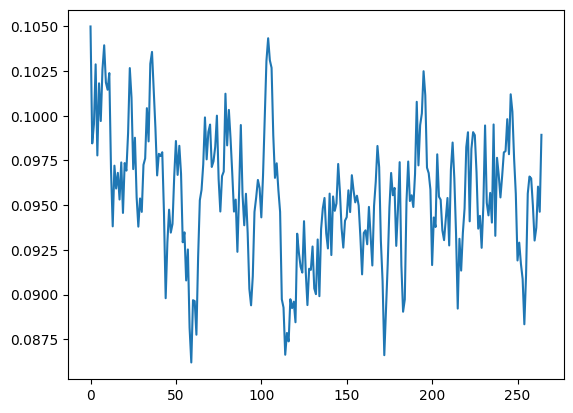

In [29]:
import matplotlib.pyplot as plt

# plt.plot(range(len(arr)), arr)
plt.plot(range(len(moving_averages)), moving_averages)
plt.show()

sample [[0 1]
 [0 0]
 [0 0]
 ...
 [1 1]
 [1 0]
 [1 1]]


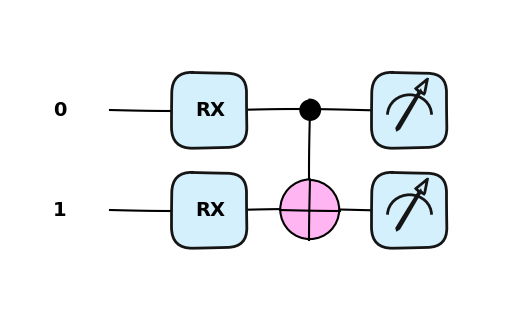

In [2]:
# Choose the device you want to use.
# dev = qml.device("lightning.qubit", wires=2, shots=1000)
dev = qml.device('qiskit.aer', wires=2, shots=1000)
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibmq_qasm_simulator')
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibm_lagos')


# Create a QNode with 2 entangled qubits
@qml.qnode(dev)
def circuit(theta):
    qml.RX(theta[0],wires=0)
    qml.RX(theta[1],wires=1)
    qml.CNOT(wires=[0,1])
    # return qml.expval(qml.PauliZ(wires=range(0,1)))
    return qml.sample()

thetas = np.array([[1.0,2.0],[1.0,2.0]],requires_grad=True)
# Draw your circuit
qml.draw_mpl(circuit,style='pennylane')(thetas)

# Run your circuit
print('sample', np.concatenate(circuit(thetas), axis=0))
# print('sample', circuit(thetas))

In [3]:
def cost(circuit, thetas):
    c = circuit(thetas)
    return np.mean(c)

In [4]:
cost(circuit, thetas)

0.42425

In [5]:
opt = qml.GradientDescentOptimizer(0.01)

In [6]:
cost_history = []
for it in range(10):
# for it in range(steps):
    thetas, prev_cost = opt.step_and_cost(lambda thetas: cost(circuit, thetas), thetas)
    
    # clear_output(wait=True)

    print("Step {:3d}       Cost_L = {:9.7f}".format(it, prev_cost), flush=True)
    cost_history.append(prev_cost)

ValueError: shape-mismatch for sum

In [6]:
n_qubits = 3
ancilla_idx = 3

In [7]:
dev = qml.device("lightning.qubit", wires=n_qubits*2, shots=1000)

In [8]:
from problems.toy_problem import *
problem = ToyProblem(
    n_qubits=n_qubits,
)

In [9]:
@qml.qnode(dev)
def hadamard_overlap_test(weights, problem, l=None, lp=None, part=None):
    """implements the overlap test for C_G"""

    n_qubits = problem.get_n_qubits()
    ancilla_idx = n_qubits * 2

    # H on ancilla index
    qml.Hadamard(ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x> applied to the top half
    problem.variational_block(weights, offset=n_qubits)

    # unitary U_b associated to the problem vector |b> applied to the bottom half
    # In this specific example Adjoint(U_b) = U_b.
    problem.U_b()

    # Controlled application of the unitary component A_l of the problem matrix A on the top half.
    problem.CA(ancilla_idx, l, offset=n_qubits)

    # Controlled application of Adjoint(A_lp) applied to the bottom half
    # In this specific example Adjoint(A_lp) = A_lp. #TODO: is it really?
    problem.CA(ancilla_idx, lp)

    if part == "Im":
        qml.RZ(phi=-np.pi/2, wires=ancilla_idx)

    # bell basis observable
    [qml.CNOT(wires=(i+n_qubits, i)) for i in range(n_qubits)]
    [qml.Hadamard(wires=i) for i in range(n_qubits, n_qubits*2 + 1)]

    # to get P(0) - P(1) we need to perform linear classical post-processing which involves using the probabilities
    return qml.probs(wires=range(n_qubits*2 + 1))

In [10]:
w = 0.001 * np.random.randn(problem.param_shape, requires_grad=True)

qml.draw_mpl(hadamard_overlap_test,style='pennylane')(w, 1, 1, "Re")

AttributeError: 'int' object has no attribute 'get_n_qubits'

In [1]:
def get_bin(bitstring: str):
    """
    @param
    bitstring: a measurement outcome as a bitstring
    return: (-1 or 1, corresponding to whether the prob on the bitstring should be added or subtracted)
    """
    acc = 1

    n_qubits = (len(bitstring) - 1) // 2

    if bitstring[-1] == "1":
        acc *= -1

    for i in range(n_qubits):
        if bitstring[i] == bitstring[i+n_qubits] == "1":
            acc *= -1

    return acc

In [11]:
def get_bin_int(state: int, n_qubits):
    """
    @param
    state: a measurement outcome as an int 
    return: (-1 or 1, corresponding to whether the prob on the bitstring should be added or subtracted)
    """
    acc = 1

    # if aux qubit is 1
    if state & 2**(n_qubits*2):
        acc *= -1

    for i in range(n_qubits):
        if state & 2**i and state & 2**(i + n_qubits):
            acc *= -1

    return acc

In [9]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    # return qml.expval(qml.PauliZ(wires=range(0,1)))
    return qml.probs(wires=range(2))

In [10]:
circuit()

tensor([0., 0., 1., 0.], requires_grad=True)

In [7]:
import numpy as np
p = np.array([1,2,3])
q = np.array([1.02,2.3,2.88])

hellinger(p, q)

0.05467171975250919